In [1]:
import deepxde as dde
import numpy as np

import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

import pandas as pd

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [3]:
dde.config.set_random_seed(1234)
dde.config.set_default_float("float64")

Set the default float type to float64


In [4]:
#computational domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])

In [5]:
#pde
def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    return u_xx + u_yy

In [6]:
#bcs problem 2
bc_top2 = dde.icbc.DirichletBC(geom, 
                              lambda x: -x[:, 0:1]**2 + x[:, 0:1], 
                              lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 1.0),)

bc_bottom2 = dde.icbc.DirichletBC(geom,
                                 lambda x: -x[:, 0:1]**2 + x[:, 0:1], 
                                 lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 0.0),)

bc_left2 = dde.icbc.DirichletBC(geom,
                               lambda x: -x[:, 1:2]**2 + x[:, 1:2], 
                               lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0.0),)

bc_right2 = dde.icbc.DirichletBC(geom,
                                lambda x: -x[:, 1:2]**2 + x[:, 1:2], 
                                lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1.0),)

In [7]:
data1 = dde.data.PDE(
    geom,
    pde,
    [
        bc_top2,
        bc_bottom2,
        bc_left2,
        bc_right2
    ],
    num_domain=500,
    num_boundary=100,
    train_distribution='Sobol'
    )

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(


In [11]:
net_square_s = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_long_s = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_oblong_s = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

In [12]:
model_square_s = dde.Model(data1, net_square_s)
model_long_s = dde.Model(data1, net_long_s)
model_oblong_s = dde.Model(data1, net_oblong_s)

## Soft Constraints - Loss

### Soft Constraints - Square

In [13]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_s.compile("adam", lr=0.001)
model_square_s.train(iterations=10000, display_every=1000)
model_square_s.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...




C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 4.389923 s


'compile' took 6.652254 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.79e-02, 1.47e-02, 3.63e-02, 1.86e-02, 2.24e-02]    [1.79e-02, 1.47e-02, 3.63e-02, 1.86e-02, 2.24e-02]    []  
1000      [6.15e-06, 5.49e-03, 4.54e-03, 4.48e-03, 5.49e-03]    [6.15e-06, 5.49e-03, 4.54e-03, 4.48e-03, 5.49e-03]    []  
2000      [5.95e-05, 5.33e-03, 4.47e-03, 4.43e-03, 5.32e-03]    [5.95e-05, 5.33e-03, 4.47e-03, 4.43e-03, 5.32e-03]    []  
3000      [3.19e-05, 5.32e-03, 4.48e-03, 4.46e-03, 5.39e-03]    [3.19e-05, 5.32e-03, 4.48e-03, 4.46e-03, 5.39e-03]    []  
4000      [6.73e-05, 5.31e-03, 4.47e-03, 4.44e-03, 5.32e-03]    [6.73e-05, 5.31e-03, 4.47e-03, 4.44e-03, 5.32e-03]    []  
5000      [8.82e-05, 5.28e-03, 4.52e-03, 4.44e-03, 5.25e-03]    [8.82e-05, 5.28e-03, 4.52e-03, 4.44e-03, 5.25e-03]    []  
6000      [1.02e-07, 5.63e-03, 4.64e-03, 4.52e-03, 5.63e-03]

In [14]:
dde.utils.external.save_loss_history(loss_history_square, 'laplace2_soft_square_loss')

Saving loss history to laplace2_soft_square_loss ...


In [151]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\2120484555.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_square_loss",


In [152]:
loss1 = pde_loss_array + bc_loss_array

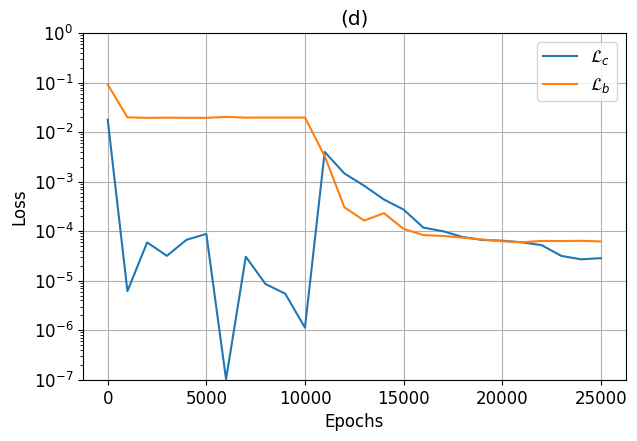

In [153]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)
plt.plot(epochs_array, bc_loss_array)


plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(d)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,1)
plt.grid()

plt.savefig("laplace2_soft_square_loss_pic", bbox_inches = 'tight')

### Soft Constraints - Long

In [18]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_s.compile("adam", lr=0.001)
model_long_s.train(iterations=10000, display_every=1000)
model_long_s.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.097796 s



C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.856616 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.85e-02, 1.80e-01, 1.36e-01, 6.48e-02, 2.59e-01]    [6.85e-02, 1.80e-01, 1.36e-01, 6.48e-02, 2.59e-01]    []  
1000      [4.60e-05, 5.41e-03, 4.47e-03, 4.43e-03, 5.27e-03]    [4.60e-05, 5.41e-03, 4.47e-03, 4.43e-03, 5.27e-03]    []  
2000      [7.23e-05, 5.35e-03, 4.39e-03, 4.26e-03, 5.16e-03]    [7.23e-05, 5.35e-03, 4.39e-03, 4.26e-03, 5.16e-03]    []  
3000      [7.71e-04, 5.30e-03, 3.46e-03, 3.26e-03, 4.94e-03]    [7.71e-04, 5.30e-03, 3.46e-03, 3.26e-03, 4.94e-03]    []  
4000      [1.35e-03, 4.79e-03, 1.33e-03, 1.31e-03, 4.54e-03]    [1.35e-03, 4.79e-03, 1.33e-03, 1.31e-03, 4.54e-03]    []  
5000      [7.72e-03, 7.21e-03, 1.27e-03, 1.64e-03, 6.07e-03]    [7.72e-03, 7.21e-03, 1.27e-03, 1.64e-03, 6.07e-03]    []  
6000      [6.32e-04, 6.83e-04, 4.34e-05, 5.81e-05, 5.24e-04]    [6.32e-04, 6.83e-04, 4

In [19]:
dde.utils.external.save_loss_history(loss_history_long, 'laplace2_soft_long_loss')

Saving loss history to laplace2_soft_long_loss ...


In [156]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\66092829.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_long_loss",


In [157]:
loss2 = pde_loss_array + bc_loss_array

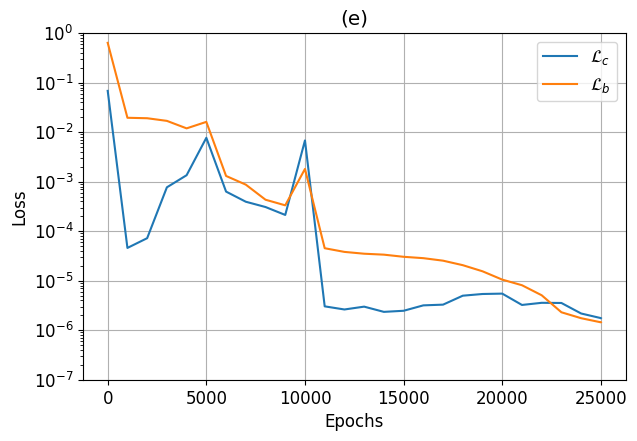

In [158]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)
plt.plot(epochs_array, bc_loss_array)

plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(e)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,1)
plt.grid()

plt.savefig("laplace2_soft_long_loss_pic", bbox_inches = 'tight')

### Soft Constraints - Oblong

In [23]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_s.compile("adam", lr=0.001)
model_oblong_s.train(iterations=10000, display_every=1000)
model_oblong_s.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.756261 s

'compile' took 6.502887 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.80e-03, 2.48e-02, 2.79e-02, 3.13e-02, 2.36e-02]    [1.80e-03, 2.48e-02, 2.79e-02, 3.13e-02, 2.36e-02]    []  
1000      [7.18e-06, 5.42e-03, 4.54e-03, 4.44e-03, 5.41e-03]    [7.18e-06, 5.42e-03, 4.54e-03, 4.44e-03, 5.41e-03]    []  
2000      [3.38e-05, 5.39e-03, 4.54e-03, 4.43e-03, 5.32e-03]    [3.38e-05, 5.39e-03, 4.54e-03, 4.43e-03, 5.32e-03]    []  
3000      [4.55e-05, 5.36e-03, 4.52e-03, 4.44e-03, 5.30e-03]    [4.55e-05, 5.36e-03, 4.52e-03, 4.44e-03, 5.30e-03]    []  
4000      [3.41e-04, 5.30e-03, 4.29e-03, 3.88e-03, 5.18e-03]    [3.41e-04, 5.30e-03, 4.29e-03, 3.88e-03, 5.18e-03]    []  
5000      [1.85e-03, 6.68e-03, 5.43e-03, 4.75e-03, 6.84e-03]    [1.85e-03, 6.68e-03, 5.43e-03, 4.75e-03, 6.84e-03]    []  
6000      [8.96e-04, 4.73e-03, 3.33e-03, 2.70e-03, 5.33e-03] 

In [24]:
dde.utils.external.save_loss_history(loss_history_oblong, 'laplace2_soft_oblong_loss')

Saving loss history to laplace2_soft_oblong_loss ...


In [142]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\1600593431.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_oblong_loss",


In [143]:
loss3 = pde_loss_array + bc_loss_array

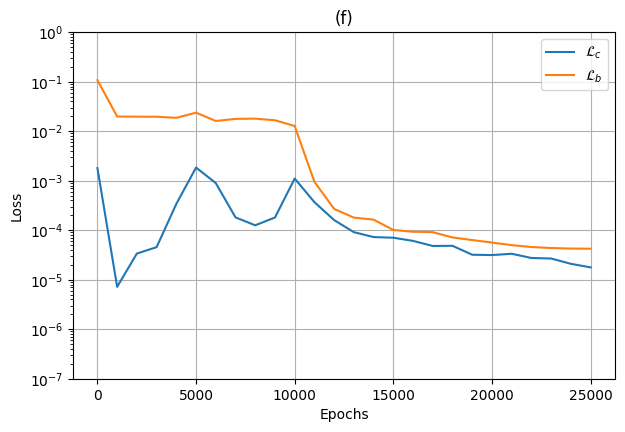

In [27]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)
plt.plot(epochs_array, bc_loss_array)

plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(f)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,1)
plt.grid()

plt.savefig("laplace2_soft_oblong_loss_pic", bbox_inches = 'tight')

## Soft Constraints - Absolute Error

In [122]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

In [131]:
def u200(x, y): 
    sum = 0
    for k in range(1,200):
        sum = sum + -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*(1-x)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*x*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*(1-y)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*y*k))/(np.pi**3 * k**3)
    return sum

## Soft Constraints - Relative Error

#### Evaluation Points

In [132]:
test = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1)], axis=1)

In [133]:
u_exact = u200(points[0],points[1])

u_square_s = model_square_s.predict(test)
u_long_s = model_long_s.predict(test)
u_oblong_s = model_oblong_s.predict(test)

u_square_h = model_square_h.predict(test)
u_long_h = model_long_h.predict(test)
u_oblong_h = model_oblong_h.predict(test)

In [134]:
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_s.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_square_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_long_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u_exact,15), np.round(u_oblong_h.flatten(),15)))

0.009025019720482249
0.0012898119062264497
0.007098253858890646
9.606087542659531e-05
6.823322799467798e-05
0.0002039435798350042


#### Training Points

In [137]:
u_exact = u200(data2.train_x_all.T[0], data2.train_x_all.T[1])

u_square_s = model_square_s.predict(data2.train_x_all)
u_long_s = model_long_s.predict(data2.train_x_all)
u_oblong_s = model_oblong_s.predict(data2.train_x_all)

u_square_h = model_square_h.predict(data2.train_x_all)
u_long_h = model_long_h.predict(data2.train_x_all)
u_oblong_h = model_oblong_h.predict(data2.train_x_all)

print(dde.metrics.l2_relative_error(u_exact, u_square_s.T))
print(dde.metrics.l2_relative_error(u_exact, u_long_s.T))
print(dde.metrics.l2_relative_error(u_exact, u_oblong_s.T))

print(dde.metrics.l2_relative_error(u_exact, u_square_h.T))
print(dde.metrics.l2_relative_error(u_exact, u_long_h.T))
print(dde.metrics.l2_relative_error(u_exact, u_oblong_h.T))

0.00889871289281774
0.0015025200891951192
0.007145110051702505
9.988264752729458e-05
6.818694968901401e-05
0.00020561508196974499


## Soft Constraints - Absolute Error

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\2247737728.py:50: UserWarning: Log scale: values of z <= 0 have been masked
  er4 = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
C:\Users\charl\AppData\Local\Temp\ipykernel_16432\2247737728.py:61: UserWarning: Log scale: values of z <= 0 have been masked
  er5 = ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
C:\Users\charl\AppData\Local\Temp\ipykernel_16432\2247737728.py:72: UserWarning: Log scale: values of z <= 0 have been masked
  er6 = ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)


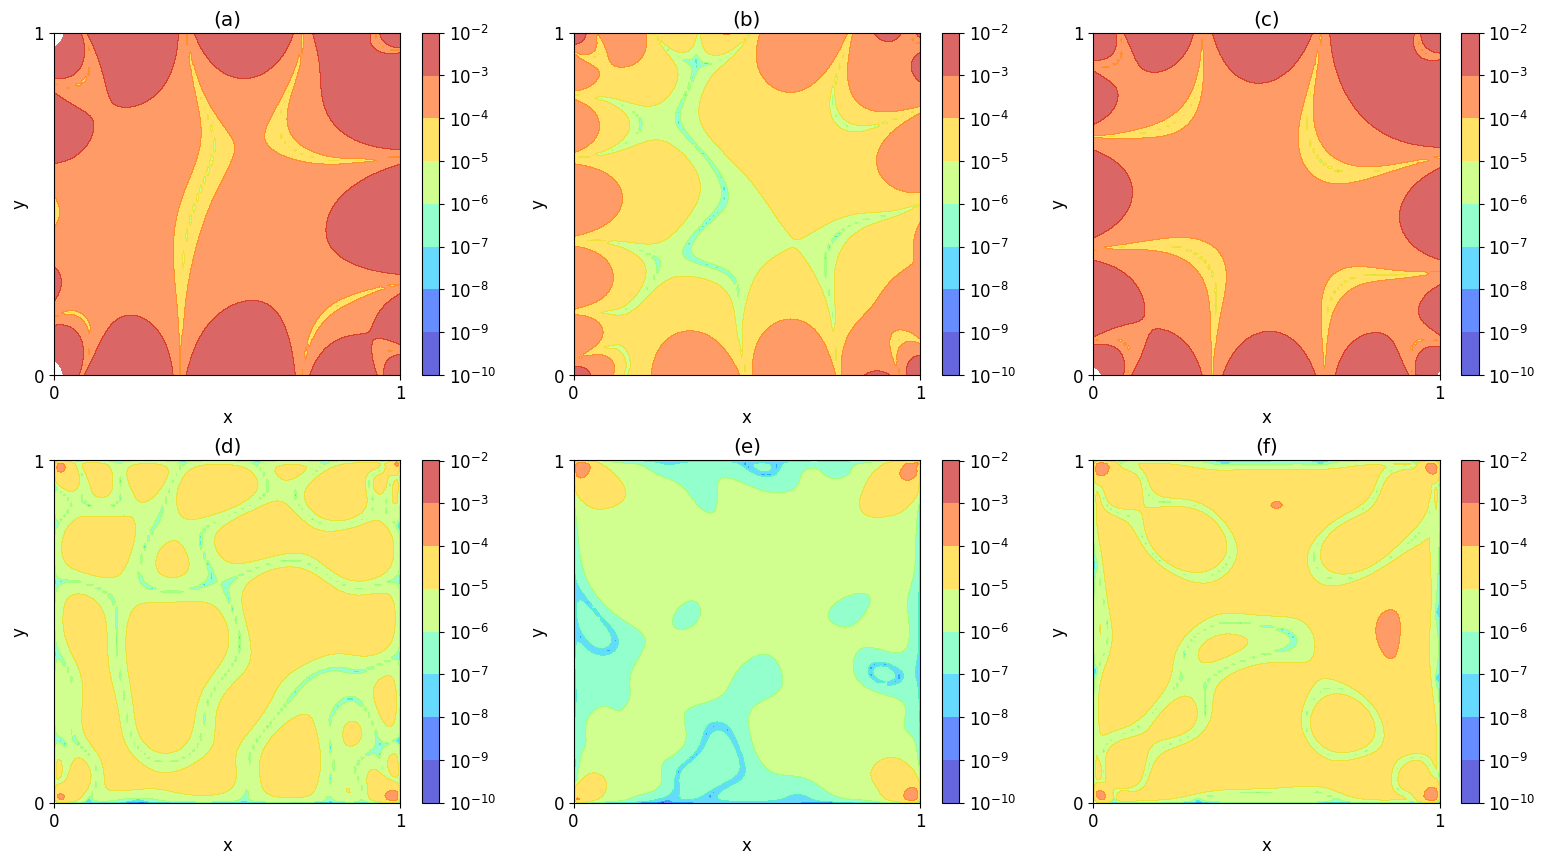

In [93]:
from matplotlib import cm, ticker

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(19,10))

levels = np.logspace(np.log10(10**-10), np.log10(10**-2), num=9)

#IMAGE 2
ax2 = fig.add_subplot(2,3,1)
error_square = np.abs(u_square_s.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er1 = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('(a)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#IMAGE 3
ax3 = fig.add_subplot(2,3,2)
error_long = np.abs(u_long_s.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er2 = ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('(b)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#IMAGE 4
ax4 = fig.add_subplot(2,3,3)
error_oblong = np.abs(u_oblong_s.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er3 = ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('(c)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])

#IMAGE 2
ax2 = fig.add_subplot(2,3,4)
error_square = np.abs(u_square_h.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er4 = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('(d)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#IMAGE 3
ax3 = fig.add_subplot(2,3,5)
error_long = np.abs(u_long_h.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er5 = ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('(e)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#IMAGE 4
ax4 = fig.add_subplot(2,3,6)
error_oblong = np.abs(u_oblong_h.reshape((Nx,Ny)) - u_exact.reshape((Nx,Ny)))
er6 = ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('(f)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])

fig.colorbar(er1)
fig.colorbar(er2)
fig.colorbar(er3)
fig.colorbar(er4)
fig.colorbar(er5)
fig.colorbar(er6)

plt.subplots_adjust(hspace=0.25, wspace=0.2)
plt.savefig("laplace2_error", bbox_inches = 'tight')

## Hard Constraints

In [48]:
data2 = dde.data.PDE(geom, 
                        pde, 
                         [],
                        num_domain=500,
                        train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(


In [49]:
net_square_h = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_long_h = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))
net_oblong_h = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", tf.keras.initializers.GlorotUniform(seed=1234))

In [50]:
def output_transform(x,u):
    return (1-x[:,0:1]) * (-x[:,1:2]**2 + x[:,1:2]) + x[:,0:1] * (-x[:,1:2]**2 + x[:,1:2]) + (1-x[:,1:2]) * (-x[:,0:1]**2 + x[:,0:1]) + x[:,1:2] * (-x[:,0:1]**2 + x[:,0:1]) + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u

In [51]:
net_square_h.apply_output_transform(
    lambda x, u: (1-x[:,0:1]) * (-x[:,1:2]**2 + x[:,1:2]) 
    + x[:,0:1] * (-x[:,1:2]**2 + x[:,1:2]) 
    + (1-x[:,1:2]) * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,1:2] * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u
)
model_square_h = dde.Model(data2, net_square_h)

In [52]:
net_long_h.apply_output_transform(
    lambda x, u: (1-x[:,0:1]) * (-x[:,1:2]**2 + x[:,1:2]) 
    + x[:,0:1] * (-x[:,1:2]**2 + x[:,1:2]) 
    + (1-x[:,1:2]) * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,1:2] * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u
)
model_long_h = dde.Model(data2, net_long_h)

In [53]:
net_oblong_h.apply_output_transform(
    lambda x, u: (1-x[:,0:1]) * (-x[:,1:2]**2 + x[:,1:2]) 
    + x[:,0:1] * (-x[:,1:2]**2 + x[:,1:2]) 
    + (1-x[:,1:2]) * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,1:2] * (-x[:,0:1]**2 + x[:,0:1]) 
    + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u
)
model_oblong_h = dde.Model(data2, net_oblong_h)

### Hard Constraints - Square

In [54]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_h.compile("adam", lr=0.001)
model_square_h.train(iterations=10000, display_every=1000)
model_square_h.compile("L-BFGS-B")
loss_history_square, train_state_square = model_square_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.924371 s

'compile' took 9.465500 s

Training model...

0         [1.62e+01]    [1.62e+01]    []  
1000      [1.45e+00]    [1.45e+00]    []  
2000      [1.45e+00]    [1.45e+00]    []  
3000      [1.06e-01]    [1.06e-01]    []  
4000      [2.16e-01]    [2.16e-01]    []  
5000      [8.33e-01]    [8.33e-01]    []  
6000      [7.87e-02]    [7.87e-02]    []  
7000      [2.90e-02]    [2.90e-02]    []  
8000      [8.88e-02]    [8.88e-02]    []  
9000      [2.67e-01]    [2.67e-01]    []  
10000     [9.26e-02]    [9.26e-02]    []  

Best model at step 7000:
  train loss: 2.90e-02
  test loss: 2.90e-02
  test metric: []

'train' took 972.773268 s

Compiling model...
'compile' took 4.528293 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [9.26e-02]    [9.26e-02]    []  
11000     [2.34e-03]    [2.34e-03]        
12000     [1.55e-03]    [1.55e-03]        
13000     [1.07e-03]    [1.07e-03]        
14000     [7.51e-04]    [7.51e-04]        
15000    

In [56]:
dde.utils.external.save_loss_history(loss_history_square, 'laplace2_hard_square_loss')

Saving loss history to laplace2_hard_square_loss ...


In [144]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25002)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\1141530042.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_square_loss",


In [145]:
loss4 = pde_loss_array

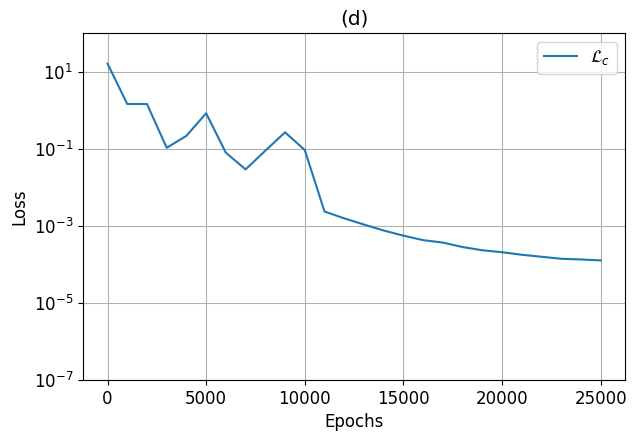

In [59]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)

plt.legend([r'$\mathcal{L}_c$'])
plt.title('(d)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,100)
plt.grid()

plt.savefig("laplace2_hard_square_loss_pic", bbox_inches = 'tight')

### Hard Constraints - Long

In [60]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_h.compile("adam", lr=0.001)
model_long_h.train(iterations=10000, display_every=1000)
model_long_h.compile("L-BFGS-B")
loss_history_long, train_state_long = model_long_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.174599 s



C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.204465 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.49e+01]    [1.49e+01]    []  
1000      [2.97e-01]    [2.97e-01]    []  
2000      [8.21e-02]    [8.21e-02]    []  
3000      [4.99e-02]    [4.99e-02]    []  
4000      [7.56e-03]    [7.56e-03]    []  
5000      [1.47e-03]    [1.47e-03]    []  
6000      [7.76e-04]    [7.76e-04]    []  
7000      [5.24e-04]    [5.24e-04]    []  
8000      [3.77e-04]    [3.77e-04]    []  
9000      [2.82e-04]    [2.82e-04]    []  
10000     [2.06e-04]    [2.06e-04]    []  

Best model at step 10000:
  train loss: 2.06e-04
  test loss: 2.06e-04
  test metric: []

'train' took 111.276583 s

Compiling model...
'compile' took 1.555014 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [2.06e-04]    [2.06e-04]    []  
11000     [1.67e-05]    [1.67e-05]        
12000     [8.75e-06]    [8.75e-06]        
13000     [5.65e-06]    [5.65e-06]        
14000     [3.70e-06]    [3

In [62]:
dde.utils.external.save_loss_history(loss_history_long, 'laplace2_hard_long_loss')

Saving loss history to laplace2_hard_long_loss ...


In [146]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\3569928800.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_long_loss",


In [147]:
loss5 = pde_loss_array

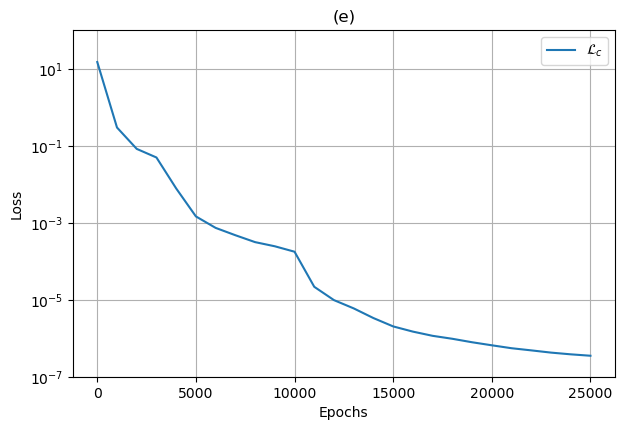

In [40]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)

plt.legend([r'$\mathcal{L}_c$'])
plt.title('(e)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,100)
plt.grid()

plt.savefig("laplace2_hard_long_loss_pic", bbox_inches = 'tight')

### Hard Constraints - Oblong

In [65]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_h.compile("adam", lr=0.001)
model_oblong_h.train(iterations=10000, display_every=1000)
model_oblong_h.compile("L-BFGS-B")
loss_history_oblong, train_state_oblong = model_oblong_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.372693 s

'compile' took 3.859730 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.61e+01]    [1.61e+01]    []  
1000      [1.45e+00]    [1.45e+00]    []  
2000      [1.45e+00]    [1.45e+00]    []  
3000      [1.45e+00]    [1.45e+00]    []  
4000      [1.45e+00]    [1.45e+00]    []  
5000      [1.45e+00]    [1.45e+00]    []  
6000      [1.45e+00]    [1.45e+00]    []  
7000      [1.45e+00]    [1.45e+00]    []  
8000      [1.45e+00]    [1.45e+00]    []  
9000      [1.45e+00]    [1.45e+00]    []  
10000     [1.45e+00]    [1.45e+00]    []  

Best model at step 10000:
  train loss: 1.45e+00
  test loss: 1.45e+00
  test metric: []

'train' took 157.655589 s

Compiling model...
'compile' took 2.167092 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [1.45e+00]    [1.45e+00]    []  
11000     [6.35e-03]    [6.35e-03]        
12000     [2.61e-03]    [2.61e-03]        
13000     [1.96e-03]    [1.96e-03]        
1

In [66]:
dde.utils.external.save_loss_history(loss_history_oblong, 'laplace2_hard_oblong_loss')

Saving loss history to laplace2_hard_oblong_loss ...


In [148]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_16432\3905139272.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_oblong_loss",


In [149]:
loss6 = pde_loss_array

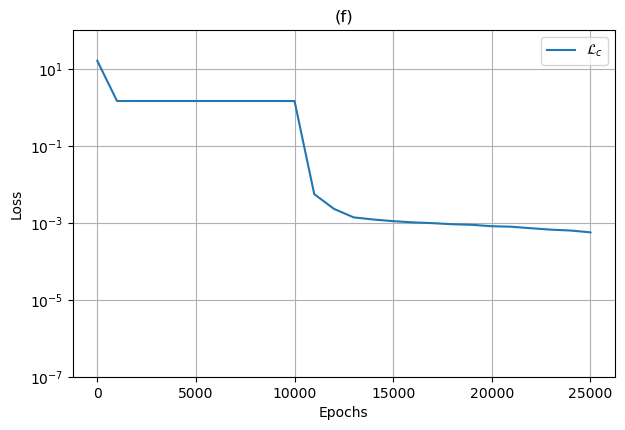

In [45]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, pde_loss_array)

plt.legend([r'$\mathcal{L}_c$'])
plt.title('(f)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,100)
plt.grid()

plt.savefig("laplace2_hard_oblong_loss_pic", bbox_inches = 'tight')

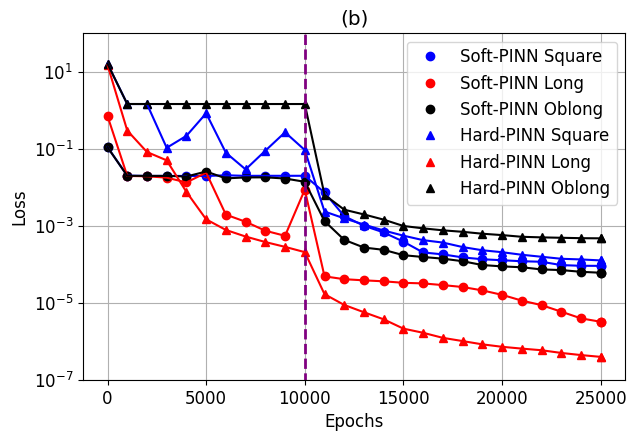

In [150]:
fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, loss1, 'o', color='blue')
plt.plot(epochs_array, loss2, 'o', color='red')
plt.plot(epochs_array, loss3, 'o', color='black')

plt.plot(epochs_array, loss4, '^', color='blue')
plt.plot(epochs_array, loss5, '^', color='red')
plt.plot(epochs_array, loss6, '^', color='black')

plt.plot(epochs_array, loss1, color='blue')
plt.plot(epochs_array, loss2, color='red')
plt.plot(epochs_array, loss3, color='black')

plt.plot(epochs_array, loss4, color='blue')
plt.plot(epochs_array, loss5, color='red')
plt.plot(epochs_array, loss6, color='black')

#plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(b)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,100)
plt.grid()

plt.vlines(x=10000, ymin=0.0000000001, ymax=100, colors='purple', ls='--', lw=2)

plt.legend(['Soft-PINN Square','Soft-PINN Long','Soft-PINN Oblong','Hard-PINN Square','Hard-PINN Long','Hard-PINN Oblong'])

#plt.savefig("laplace2_loss_pic", bbox_inches = 'tight')

## Comparison

In [47]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid1 = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid1[0].ravel(), 
    plot_grid1[1].ravel()
    ))

In [48]:
def u200(x, y): 
    sum = 0
    for k in range(1,200):
        sum = sum + -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*(1-x)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*x*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*(1-y)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*y*k))/(np.pi**3 * k**3)
    return sum

In [62]:
test = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1)], axis=1)

u_exact = u200(points[0],points[1])

u_square2 = model_square_hard2.predict(test)
u_long2 = model_long_hard2.predict(test)
u_oblong2 = model_oblong_hard2.predict(test)

u_square = model_square2_soft.predict(test)
u_long = model_long2_soft.predict(test)
u_oblong = model_oblong2_soft.predict(test)

In [63]:
print(dde.metrics.l2_relative_error(u_exact, u_square.T))
print(dde.metrics.l2_relative_error(u_exact, u_long.T))
print(dde.metrics.l2_relative_error(u_exact, u_oblong.T))

print(dde.metrics.l2_relative_error(u_exact, u_square2.T))
print(dde.metrics.l2_relative_error(u_exact, u_long2.T))
print(dde.metrics.l2_relative_error(u_exact, u_oblong2.T))

0.007272440103680857
0.001376541994203757
0.01083462441280002
0.00018520577527099172
6.62725535246421e-05
0.00031375255637783035


In [64]:
u_exact_train = u200(data2.train_x_all.T[0],
            data2.train_x_all.T[1])

u_square_train = model_square_hard2.predict(data2.train_x_all)
u_long_train = model_long_hard2.predict(data2.train_x_all)
u_oblong_train = model_oblong_hard2.predict(data2.train_x_all)

print(dde.metrics.l2_relative_error(u_exact_train, u_square_train.T))
print(dde.metrics.l2_relative_error(u_exact_train, u_long_train.T))
print(dde.metrics.l2_relative_error(u_exact_train, u_oblong_train.T))

0.0001681630419942762
6.175759850192902e-05
0.00029032148345013535


## Plot

In [152]:
u2_exact_plot = u50(points[0],points[1])
u21_exact_plot = u100(points[0],points[1])
u22_exact_plot = u200(points[0],points[1])

In [149]:
def u100(x, y): 
    sum = 0
    for k in range(1,100):
        sum = sum + -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*(1-x)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*x*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*(1-y)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*y*k))/(np.pi**3 * k**3)
    return sum

In [150]:
def u200(x, y): 
    sum = 0
    for k in range(1,200):
        sum = sum + -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*(1-x)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*x*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*(1-y)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*y*k))/(np.pi**3 * k**3)
    return sum

In [151]:
u2_exact = u50(points[0],points[1])
u21_exact = u100(points[0],points[1])
u22_exact = u200(points[0],points[1])

In [92]:
u_square_hard2 = model_square_hard2.predict(test)
u_long_hard2 = model_long_hard2.predict(test)
u_oblong_hard2 = model_oblong_hard2.predict(test)

In [93]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0, 1, 0, 1]
plot_grid1 = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid1[0].ravel(), 
    plot_grid1[1].ravel()
    ))

test = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1)], axis=1)

In [94]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 10}
plt.rc('font', **font)

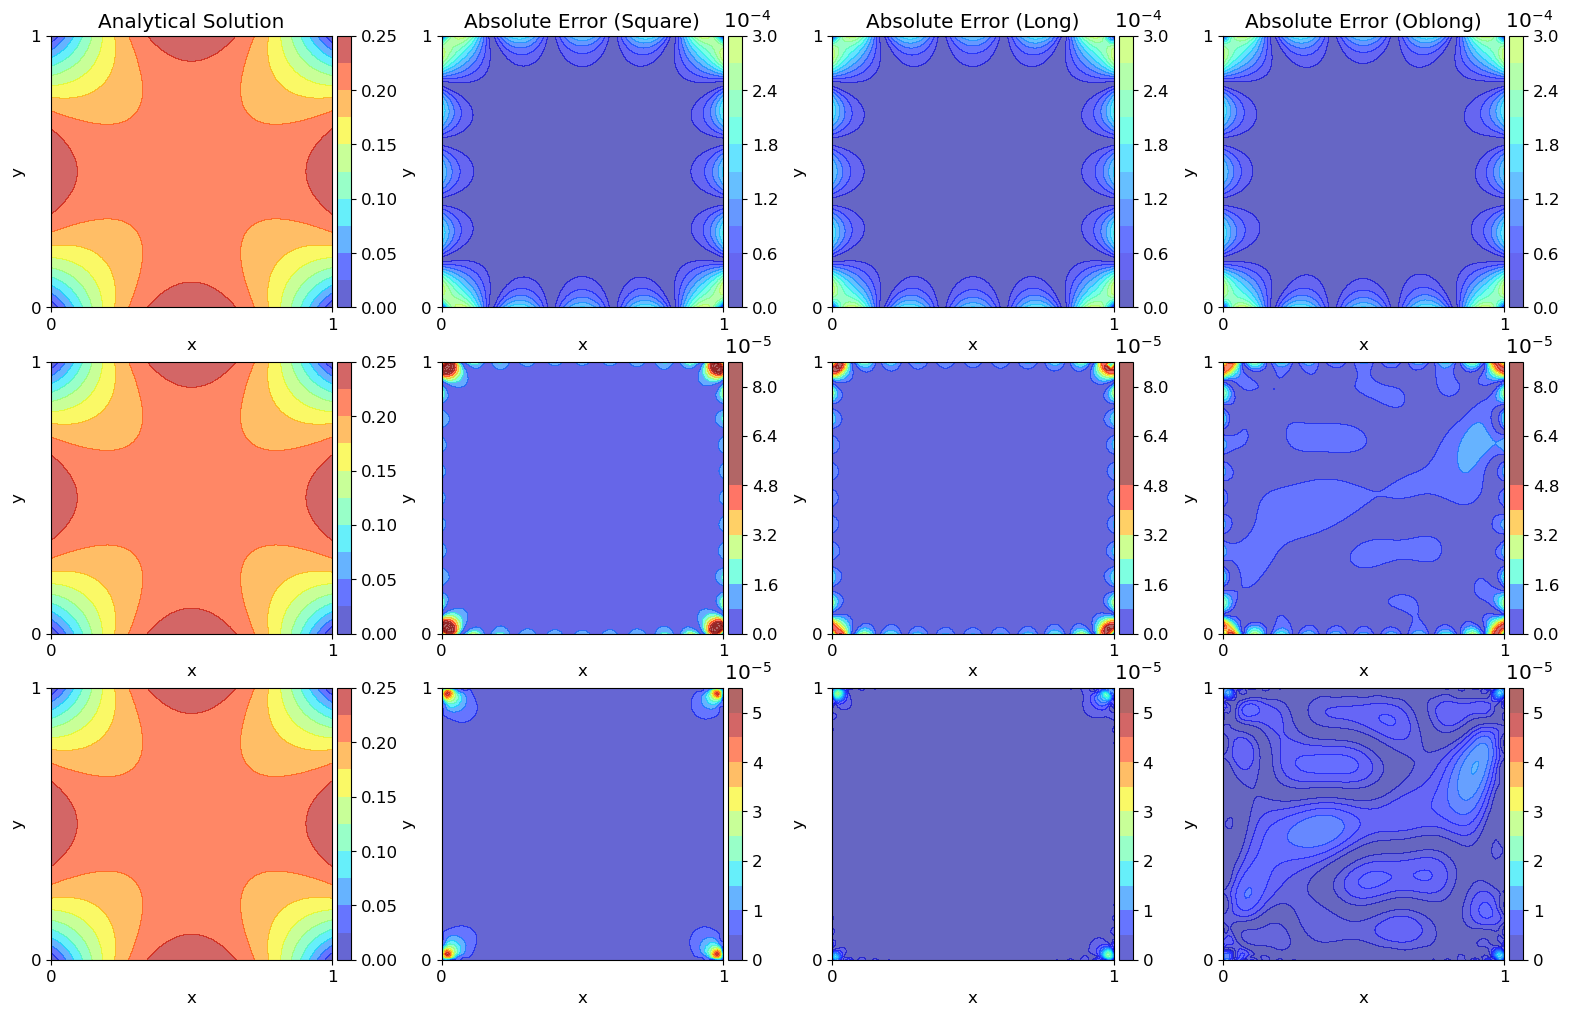

In [120]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(19,12))

vmin=0
vmax=5

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(3,4,1)
im = ax1.contourf(plot_grid1[0], plot_grid1[1], u2_exact_plot.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=0.25, levels=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Analytical Solution');
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
#IMAGE 2
ax2 = fig.add_subplot(3,4,2)
error_square = 1000*np.abs(u_square_hard2.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Absolute Error (Square)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#ax2.set_ylim(0.1,0.9)
#ax2.set_xlim(0.1,0.9)
#IMAGE 3
ax3 = fig.add_subplot(3,4,3)
error_long = 1000*np.abs(u_long_hard2.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Absolute Error (Long)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#ax3.set_ylim(0.1,0.9)
#ax3.set_xlim(0.1,0.9)
#IMAGE 4
ax4 = fig.add_subplot(3,4,4)
error_oblong = 1000*np.abs(u_oblong_hard2.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('Absolute Error (Oblong)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])
#ax4.set_ylim(0,1)
#ax4.set_xlim(-0.1,1.1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-4}$')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-4}$')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-4}$')

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(3,4,5)
im = ax1.contourf(plot_grid1[0], plot_grid1[1], u21_exact_plot.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=0.25, levels=10)
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_title('Analytical Solution');
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
#IMAGE 2
ax2 = fig.add_subplot(3,4,6)
error_square = 10000*np.abs(u_square_hard2.reshape((Nx,Ny)) - u21_exact.reshape((Nx,Ny)))
er = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_title('Absolute Error (Square)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#ax2.set_ylim(0.1,0.9)
#ax2.set_xlim(0.1,0.9)
#IMAGE 3
ax3 = fig.add_subplot(3,4,7)
error_long = 10000*np.abs(u_long_hard2.reshape((Nx,Ny)) - u21_exact.reshape((Nx,Ny)))
ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax3.set_xticks([])
ax3.set_yticks([])
#ax3.set_title('Absolute Error (Long)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#ax3.set_ylim(0.1,0.9)
#ax3.set_xlim(0.1,0.9)
#IMAGE 4
ax4 = fig.add_subplot(3,4,8)
error_oblong = 10000*np.abs(u_oblong_hard2.reshape((Nx,Ny)) - u21_exact.reshape((Nx,Ny)))
ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax4.set_xticks([])
ax4.set_yticks([])
#ax4.set_title('Absolute Error (Oblong)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])
#ax4.set_ylim(0,1)
#ax4.set_xlim(-0.1,1.1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(3,4,9)
im = ax1.contourf(plot_grid1[0], plot_grid1[1], u22_exact_plot.reshape((Nx,Ny)), cmap='jet', alpha=0.6, vmin=0, vmax=0.25, levels=10)
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_title('Analytical Solution');
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
#IMAGE 2
ax2 = fig.add_subplot(3,4,10)
error_square = 10000*np.abs(u_square_hard2.reshape((Nx,Ny)) - u22_exact.reshape((Nx,Ny)))
er = ax2.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.set_title('Absolute Error (Square)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#ax2.set_ylim(0.1,0.9)
#ax2.set_xlim(0.1,0.9)
#IMAGE 3
ax3 = fig.add_subplot(3,4,11)
error_long = 10000*np.abs(u_long_hard2.reshape((Nx,Ny)) - u22_exact.reshape((Nx,Ny)))
ax3.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax3.set_xticks([])
ax3.set_yticks([])
#ax3.set_title('Absolute Error (Long)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#ax3.set_ylim(0.1,0.9)
#ax3.set_xlim(0.1,0.9)
#IMAGE 4
ax4 = fig.add_subplot(3,4,12)
error_oblong = 10000*np.abs(u_oblong_hard2.reshape((Nx,Ny)) - u22_exact.reshape((Nx,Ny)))
ax4.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, vmin=vmin, vmax=vmax, levels=10)
ax4.set_xticks([])
ax4.set_yticks([])
#ax4.set_title('Absolute Error (Oblong)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])
#ax4.set_ylim(0,1)
#ax4.set_xlim(-0.1,1.1)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
clb=fig.colorbar(er, cax=cax, orientation='vertical')
clb.ax.set_title('$\ \ \ \ 10^{-5}$')

plt.subplots_adjust(hspace=0.2, wspace=0.3)
#plt.savefig("laplace2_hard_error_sum", bbox_inches = 'tight')